In [1]:
import envf as env
import pandas as pd
root_address = "/Users/baqia/concise_modularized_thesis_project_optimized_hyperparameters/"
import loadStuff as load
import numpy as np

/Users/baqia/miniforge3/envs/torch-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using mps device


In [47]:
#make a function to load the dataset and return the train and test dataframes. I have multiple datasets each with different number of classes,and column names. So I have to make a function for each dataset.

root_address = "/Users/baqia/concise_modularized_thesis_project_optimized_hyperparameters/"
def agnews():
    columnNames = ['label','skip','text']
    df = pd.read_csv(root_address + "agnews" +"/" + "train.csv",names = columnNames,skiprows=1)
    df.drop(columns=['skip'],inplace=True)
    df['label'] = df['label'].apply(lambda x : x -1)


    return df

def dbpedia():
    columnNames = ['label','skip','text']
    df = pd.read_csv(root_address + "dbpedia" +"/" + "train.csv",names = columnNames)


    df.drop(columns=['skip'],inplace=True)
    df['label'] = df['label'].apply(lambda x : x -1)

    return df
    
def r2():
    columnNames = ['label','text']
    df = pd.read_csv(root_address + "r2" +"/" + "r2.csv",names = columnNames)
    
    return df,df

def r5():
    columnNames = ['label','text']
    df = pd.read_csv(root_address + "r5" +"/" + "r5.csv",names = columnNames)
    return df,df

In [ ]:
#filter number of samples
def filteredDataset(datasetName):
    # if dataset is agnews call agnews function

    if datasetName == "agnews":
        df = agnews()
    elif datasetName == "dbpedia":
        df = dbpedia()
    elif datasetName == "r2":
        df = r2()
    elif datasetName == "r5":
        df = r5()
        
    


    #extract 1000 random samples of each label from df

    df = df.groupby('label').apply(lambda x: x.sample(n=1000,random_state=11)).reset_index(drop = True)
    return df

df = filteredDataset("r2")

df.head(-10)


In [ ]:

import os
import pandas as pd
from bs4 import BeautifulSoup
import envf as env
root_address = "/Users/baqia/concise_modularized_thesis_project_optimized_hyperparameters/"
data = []
extracted_folder_path = './r2/'
# Iterate over the extracted files and parse the .sgm files
extracted_files = os.listdir(root_address + env.DATASET_NAME +"/")
for file_name in [f for f in extracted_files if f.endswith('.sgm')]:
    file_path = os.path.join(extracted_folder_path, file_name)
    
    # Read and parse the content of the .sgm file
    with open(file_path, 'r', encoding='latin-1') as file:
        content = file.read()
    soup = BeautifulSoup(content, 'html.parser')
    
    # Extract documents and categories
    for doc in soup.find_all('reuters'):
        text = doc.find('text')
        body = text.find('body') if text else None
        document_text = body.get_text(strip=True) if body else ''
        #remove '\n' from the document text
        document_text = document_text.replace('\n','')
        topics = doc.find('topics')
        document_categories = [topic.get_text(strip=True) for topic in topics.find_all('d') if topic]
        
        data.append({
            'Document': document_text,
            'Categories': document_categories
        })

# Create a DataFrame and filter it for 'earn' and 'acq' categories
df_reuters = pd.DataFrame(data)
df_earn_acq = df_reuters[df_reuters['Categories'].apply(lambda x: 'earn' in x or 'acq' in x)].copy()

# Remove the documents shared by both categories and rows where the document is empty
df_earn_acq_cleaned = df_earn_acq[df_earn_acq['Categories'].apply(lambda x: not ('earn' in x and 'acq' in x)) & (df_earn_acq['Document'] != '')].copy()

# Replace the 'Categories' column values with 0 for 'earn' and 1 for 'acq'
df_earn_acq_cleaned['Categories'] = df_earn_acq_cleaned['Categories'].apply(lambda x: 0 if 'earn' in x else 1)
print(df_earn_acq_cleaned.shape)

# Save the DataFrame as a .csv file
df_earn_acq_cleaned.to_csv(root_address +'r2/r2.csv', index=False)


In [16]:

import os
from bs4 import BeautifulSoup
import pandas as pd
import envf as env
root_address = "/Users/baqia/concise_modularized_thesis_project_optimized_hyperparameters/"
# Specify the folder path where the dataset is extracted
extracted_folder_path = './r5/'

# Parsing the Dataset and Creating DataFrame
data = []
extracted_files = os.listdir(extracted_folder_path)

for file_name in extracted_files:
    if file_name.endswith('.sgm'):
        file_path = os.path.join(extracted_folder_path, file_name)
        with open(file_path, 'r', encoding='latin-1') as file:
            content = file.read()
        soup = BeautifulSoup(content, 'html.parser')
        for doc in soup.find_all('reuters'):
            text = doc.find('text')
            body = text.find('body')
            document_text = body.get_text(strip=True) if body else ''
            topics = doc.find('topics')
            document_categories = [topic.get_text(strip=True) for topic in topics.find_all('d')]
            data.append({'Document': document_text, 'Categories': document_categories})

df_reuters = pd.DataFrame(data)

# Filtering and Cleaning DataFrame
target_categories = ['earn', 'acq', 'crude', 'trade', 'money-fx']
filtered_df = df_reuters[df_reuters['Categories'].apply(lambda x: any(category in target_categories for category in x))] #filter classes
filtered_df = filtered_df[filtered_df['Document'].apply(lambda x: len(x.strip()) > 0)] #empty document
single_category_df = filtered_df[filtered_df['Categories'].apply(lambda x: len(set(x).intersection(target_categories)) == 1)].copy()

#remove items from Category item's list that are not in target_categories
single_category_df['Categories'] = single_category_df['Categories'].apply(lambda x: list(set(x).intersection(target_categories)))
# Replacing Categories and Modifying DataFrame
category_mapping = {'earn': 0, 'acq': 1, 'crude': 2, 'trade': 3, 'money-fx': 4}
single_category_df['Category'] = single_category_df['Categories'].apply(lambda x: category_mapping.get(x[0], -1))
single_category_df.drop(columns=['Categories'], inplace=True)
print(single_category_df.shape)
# Save the DataFrame as a .csv file
# single_category_df.to_csv(root_address + 'r5/r5.csv', index=False)

In [ ]:

single_category_df['Document'].apply(lambda x: len(x)).max()

In [ ]:

single_category_df['Category'].value_counts()

In [ ]:

#load r2 and r5 datasets
import pandas as pd
import envf as env

root_address = "/Users/baqia/concise_modularized_thesis_project_optimized_hyperparameters/"
def r2():
    df = pd.read_csv(root_address + "r2" +"/" + "r2.csv")
    return df

def r5():
    df = pd.read_csv(root_address + "r5" +"/" + "r5.csv")
    return df

df = r5()
df.head(-10)



In [39]:
df = pd.read_csv(path,names=['label','QuesTitle','quesContent','best_answer'])
#remove samples with no best answer
df = df[df['best_answer'].notna()]
#replace quesConcent NAN with empty string
df['quesContent'].fillna('',inplace=True)
df['text'] = df['QuesTitle'] + df['quesContent'] + df['best_answer']
df.drop(columns=['QuesTitle','quesContent','best_answer'],inplace=True)


In [36]:
df['text'] = df['QuesTitle'] + df['quesContent'] + df['best_answer']

In [38]:
df['QuesTitle'].isna().sum()

0

In [40]:
# print number of nan values
print(df.isna().sum())

label               0
QuesTitle           0
quesContent    621766
best_answer         0
dtype: int64


In [43]:
path = "/Users/baqia/Downloads/yahoo_answers_csv/train.csv"

#load the csv file it contains 4 columns. 1st column has class index (1 to 10),second has question title,third has question content and fourth has best answer. Concatinate the 2,3,4th column and drop the original ones. Rename the columns as label and text
df = pd.read_csv(path,names=['label','QuesTitle','quesContent','best_answer'])
df = df[df['best_answer'].notna()] #remove samples where there is no best answer because thats what we are picking for every other sample
df['quesContent'].fillna('',inplace=True) #fill nan values with empty string bcos next step adds nan to the string which is NAN
df['text'] = df['QuesTitle'] + df['quesContent'] + df['best_answer']
df.drop(columns=['QuesTitle','quesContent','best_answer'],inplace=True)
df['label'] = df['label'].apply(lambda x : x -1)
df.head(-10)


# store this dataframe as a csv file at "/Users/baqia/concise_modularized_thesis_project_optimized_hyperparameters/yahoo"
df.to_csv(root_address + "yahoo" +"/" + "train.csv",index=False)

/var/folders/nx/yktv6qmd5h76h8vcy2mwth5h0000gn/T/ipykernel_67353/2584064272.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['text'].apply(lambda x: len(x)), bins=100)


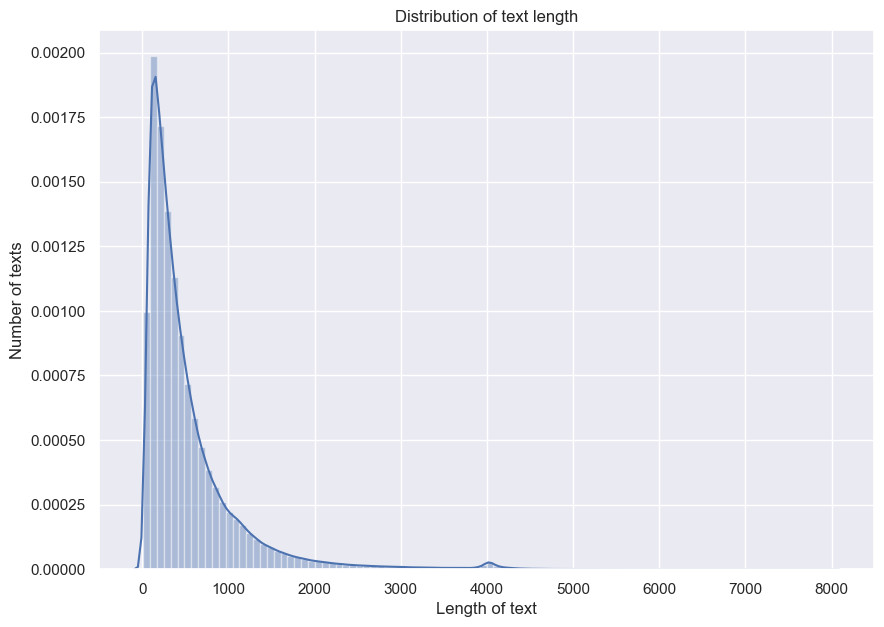

In [42]:
# plot the distribution of length of the text in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 7))
sns.distplot(df['text'].apply(lambda x: len(x)), bins=100)
plt.xlabel('Length of text')
plt.ylabel('Number of texts')
plt.title('Distribution of text length')
plt.show()


<h2><center>creating splits</center></h2>

In [2]:
df = load.r5()
df = df.sample(frac=1).reset_index(drop=True)
folds = np.array_split(df, 5)
print(folds[4]['label'].value_counts())
#store the folds in a pickle file
import pickle
with open(root_address + "r5" +"/" + "folds.pickle", 'wb') as f:
    pickle.dump(folds, f)
#load the folds from the pickle file
import pickle
with open(root_address + "r5" +"/" + "folds.pickle", 'rb') as f:
    folds = pickle.load(f)

0    749
1    426
4    130
2    101
3     99
Name: label, dtype: int64


In [2]:

df = load.agnews()
x = 4000
folds = []
for i in range(5):
    start_idx = i * x
    end_idx = start_idx + x
    folds.append(df.iloc[start_idx:end_idx].reset_index(drop=True))
print(folds[0]['label'].value_counts())
#store the folds in a pickle file
import pickle
with open(root_address + "agnews" +"/" + "folds.pickle", 'wb') as f:
    pickle.dump(folds, f)

#load the folds from the pickle file
import pickle
with open(root_address + "agnews" +"/" + "folds.pickle", 'rb') as f:
    folds = pickle.load(f)
    

3    1217
0     998
2     988
1     797
Name: label, dtype: int64


In [2]:
df = load.dbpedia()

x = 14000

folds = []
df = df.sample(frac=1).reset_index(drop=True)
for i in range(5):
    start_idx = i * x
    end_idx = start_idx + x
    folds.append(df.iloc[start_idx:end_idx].reset_index(drop=True))

print(folds[0]['label'].value_counts())
#store the folds in a pickle file
import pickle
with open(root_address + "dbpedia" +"/" + "folds.pickle", 'wb') as f:
    pickle.dump(folds, f)

#load the folds from the pickle file
import pickle
with open(root_address + "dbpedia" +"/" + "folds.pickle", 'rb') as f:
    folds = pickle.load(f)
    

3     1056
0     1041
4     1032
5     1024
8     1016
12    1006
6     1006
2     1001
10     993
7      981
1      975
9      968
13     953
11     948
Name: label, dtype: int64


In [3]:
df = load.yahoo()

x = 10000

folds = []
df = df.sample(frac=1).reset_index(drop=True)
for i in range(5):
    start_idx = i * x
    end_idx = start_idx + x
    folds.append(df.iloc[start_idx:end_idx].reset_index(drop=True))

print(folds[0]['label'].value_counts())


5    1042
9    1029
2    1025
6    1022
3    1020
8    1006
7    1001
0     985
4     940
1     930
Name: label, dtype: int64


In [4]:

#store the folds in a pickle file
import pickle
with open(root_address + "yahoo" +"/" + "folds.pickle", 'wb') as f:
    pickle.dump(folds, f)

#load the folds from the pickle file
import pickle
with open(root_address + "yahoo" +"/" + "folds.pickle", 'rb') as f:
    folds = pickle.load(f)